<a href="https://colab.research.google.com/github/Achuttarsing/simple_3d_autoencoder/blob/master/simple_3d_autoencoder_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clone repository

In [1]:
!git clone https://github.com/Achuttarsing/simple_3d_autoencoder.git

Cloning into 'simple_3d_autoencoder'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 79 (delta 17), reused 57 (delta 6), pack-reused 0
Unpacking objects: 100% (79/79), done.


### Configure Google Colab

In [2]:
%tensorflow_version 1.x
import sys
import tensorflow
print(tensorflow.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline

TensorFlow 1.x selected.
1.15.2


W0830 09:05:31.949875 140685703853952 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/tensorflow_estimator/python/estimator/api/_v1/estimator/__init__.py:12: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



### Get data (if you want to use the defaut chair dataset)

In [ ]:
%cd simple_3d_autoencoder/
!./download_data.sh

### Import the library

In [6]:
%cd ..
import os.path as osp

from simple_3d_autoencoder.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from simple_3d_autoencoder.src.autoencoder import Configuration as Conf
from simple_3d_autoencoder.src.point_net_ae import PointNetAutoEncoder

from simple_3d_autoencoder.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from simple_3d_autoencoder.src.tf_utils import reset_tf_graph
from simple_3d_autoencoder.src.general_utils import plot_3d_point_cloud

W0830 09:07:23.470408 140685703853952 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/tflearn/helpers/summarizer.py:9: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0830 09:07:23.471328 140685703853952 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/tflearn/helpers/trainer.py:25: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0830 09:07:23.482604 140685703853952 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/tflearn/collections.py:13: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0830 09:07:23.489850 140685703853952 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/tflearn/config.py:123: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0830 09:07:23.511291 140685703853952 module_wrapper.py:139] From /tensorflow-1.15.2/python2.7/tflearn/config.py:129: The name tf.add_to_collectio

/content


### Configure data

In [7]:
top_out_dir = 'simple_3d_autoencoder/data/'          # Use to save Neural-Net check-points etc.
top_in_dir = 'simple_3d_autoencoder/data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'chamfer'                   # Loss to optimize: 'emd' or 'chamfer'
class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()

Give me the class name (e.g. "chair"): chair


In [8]:
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

6778 pclouds were loaded. They belong in 1 shape-classes.


### Configure Training

In [9]:
train_params = default_train_params()
train_params['training_epochs'] = 10
train_params

{'batch_size': 50,
 'denoising': False,
 'learning_rate': 0.0005,
 'loss_display_step': 1,
 'saver_step': 10,
 'training_epochs': 10,
 'z_rotate': False}

In [10]:
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [11]:
conf = Conf(n_input = [n_pc_points, 3],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 5   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

### Load model checkpoint (if possible)

In [12]:
load_pre_trained_ae = False
restore_epoch = 500
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

### Train the model

In [13]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

W0830 09:08:08.911349 140685703853952 module_wrapper.py:139] From simple_3d_autoencoder/src/tf_utils.py:39: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0830 09:08:08.913021 140685703853952 module_wrapper.py:139] From simple_3d_autoencoder/src/neural_net.py:17: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 09:08:08.916965 140685703853952 module_wrapper.py:139] From simple_3d_autoencoder/src/neural_net.py:22: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0830 09:08:08.918906 140685703853952 module_wrapper.py:139] From simple_3d_autoencoder/src/neural_net.py:24: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0830 09:08:08.929960 140685703853952 module_wrapper.py:139] From simple_3d_autoencoder/src/autoencoder.py:99: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder 

Building Encoder
encoder_conv_layer_0 conv params =  256 bnorm params =  128
Tensor("single_class_ae_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("single_class_ae_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512

W0830 09:08:09.319413 140685703853952 module_wrapper.py:139] From simple_3d_autoencoder/src/point_net_ae.py:46: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0830 09:08:09.322851 140685703853952 module_wrapper.py:139] From simple_3d_autoencoder/src/point_net_ae.py:46: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



 bnorm params =  256
Tensor("single_class_ae_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("single_class_ae_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size: 524288 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("single_class_ae_2/Relu_4:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

Tensor("single_class_ae_2/Max:0", shape=(?, 128), dtype=float32)
Building Decoder
decoder_fc_0 FC params =  33024 Tensor("single_class_ae_2/Relu_5:0", shape=(?, 256), dtype=float32)
output size: 256 

decoder_fc_1 FC params =  65792 Tensor("single_class_ae_2/Relu_6:0", shape=(?, 256), dtype=float32)
output size: 256 

decoder_fc_2 FC params =  1579008 Tensor("single_class_ae_2/decoder_fc_2/BiasAdd:0", shape=(?, 6144), dtype=float32)
output size: 6144 



W0830 09:08:09.377254 140685703853952 module_wrapper.py:139] From simple_3d_autoencoder/src/point_net_ae.py:98: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0830 09:08:10.220890 140685703853952 module_wrapper.py:139] From simple_3d_autoencoder/src/point_net_ae.py:57: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0830 09:08:10.222472 140685703853952 module_wrapper.py:139] From simple_3d_autoencoder/src/point_net_ae.py:61: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0830 09:08:10.404705 140685703853952 module_wrapper.py:139] From simple_3d_autoencoder/src/point_net_ae.py:65: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.

W0830 09:08:10.411845 140685703853952 module_wrapper.py:139] From simple_3d_autoencoder/src/point_net_ae.py:68: The name tf.Session is deprecated. Ple

In [14]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout)
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.1681', 'loss=', '0.004195954')
('Epoch:', '0002', 'training time (minutes)=', '0.1064', 'loss=', '0.001711766')
('Epoch:', '0003', 'training time (minutes)=', '0.1062', 'loss=', '0.001486035')
('Epoch:', '0004', 'training time (minutes)=', '0.1057', 'loss=', '0.001388567')
('Epoch:', '0005', 'training time (minutes)=', '0.1058', 'loss=', '0.001279980')
('Epoch:', '0006', 'training time (minutes)=', '0.1056', 'loss=', '0.001215742')
('Epoch:', '0007', 'training time (minutes)=', '0.1058', 'loss=', '0.001146428')
('Epoch:', '0008', 'training time (minutes)=', '0.1056', 'loss=', '0.001112840')
('Epoch:', '0009', 'training time (minutes)=', '0.1055', 'loss=', '0.001074166')
('Epoch:', '0010', 'training time (minutes)=', '0.1055', 'loss=', '0.001036389')


### Try the trained autoencoder

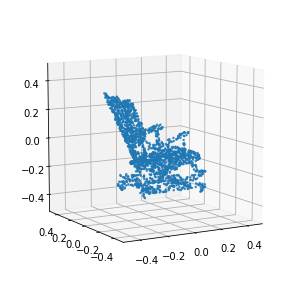

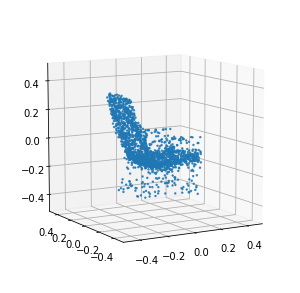

In [15]:
# feed_pc -> list of 3D point cloud
feed_pc, feed_model_names, _ = all_pc_data.next_batch(1)
for i in range(1):
    plot_3d_point_cloud(feed_pc[i][:, 0], 
                    feed_pc[i][:, 1], 
                    feed_pc[i][:, 2], in_u_sphere=True);

# encode 
latent_codes = ae.transform(feed_pc)

# decode 
reconstructions = ae.decode(latent_codes)
for i in range(1):
    plot_3d_point_cloud(reconstructions[i][:, 0], 
                    reconstructions[i][:, 1], 
                    reconstructions[i][:, 2], in_u_sphere=True);